<a href="https://colab.research.google.com/github/kchiem12/EchoAI/blob/main/EchoAI_LSTM_LocalAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [6]:
import numpy as np
from keras.utils import to_categorical
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation, TimeDistributed, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import random
from music21 import converter, instrument, note, chord, stream
import pickle
import pandas as pd

#Mounting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load preprocessed data

In [7]:
file_path = './drive/MyDrive/CS4701/notes_new'

with open(file_path, 'rb') as file:
    file_content = file.read()

print(f"File content length: {len(file_content)} bytes")
print(file_content[:100])

try:
    with open(file_path, 'rb') as file:
        buffer = []
        while True:
            try:
                buffer.append(pickle.load(file))
            except EOFError:
                break
    notes = buffer
    print("Loaded successfully.")
except EOFError:
    print("EOFError: The file might be incomplete.")
except pickle.UnpicklingError:
    print("UnpicklingError: The file might be corrupted.")
except Exception as e:
    print(f"Unexpected error: {e}")

# Flatten the list if it contains nested lists
flat_notes = []

for note in notes:
    if isinstance(note, list):
        flat_notes.extend(note)
    else:
        flat_notes.append(note)

flat_notes = flat_notes[:50000]

print("There are " + str(len(flat_notes)) + " many notes")

File content length: 23275087 bytes
b'\x80\x04\x95\x01\x00\x01\x00\x00\x00\x00\x00]\x94(\x8c\x039.2\x94\x8c\x02D4\x94\x8c\x03F#4\x94\x8c\x039.2\x94\x8c\x02A4\x94\x8c\x03F#4\x94\x8c\x039.2\x94\x8c\x02D5\x94\x8c\x02A4\x94\x8c\x039.2\x94\x8c\x03F#5\x94\x8c\x02D5\x94\x8c\x039.2\x94\x8c\x02D6\x94\x8c\x02A5\x94\x8c\x039'
Loaded successfully.
There are 50000 many notes


#Prepare sequences
This snippet prepares sequences in an expanded format as specified by "Everybody Compose: Deep Beats to Music" https://arxiv.org/pdf/2306.06284

In [8]:
def prepare_sequences_expanded(notes, seq_length=100, num_classes=None):
    pitch_set = sorted(set(notes))
    note_to_int = {note: number for number, note in enumerate(pitch_set)}

    inputs, outputs = [], []

    for i in range(0, len(notes) - seq_length, 1):
        sequence_in = notes[i:i + seq_length]
        sequence_out = notes[i:i + seq_length]
        inputs.append([note_to_int[char] for char in sequence_in])
        outputs.append([note_to_int[char] for char in sequence_out])

    num_patterns = len(inputs)

    inputs = np.reshape(inputs, (num_patterns, seq_length, 1))
    inputs = inputs / float(num_classes)
    outputs = to_categorical(outputs, num_classes=num_classes)

    return inputs, outputs

sequence_length = 64
num_vocab = len(set(flat_notes))
network_input, network_output = prepare_sequences_expanded(flat_notes, sequence_length, num_vocab)

#Model

In [9]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_output, val_output = train_test_split(
    network_input, network_output, test_size=0.2, random_state=42)

print(f"Training input shape: {train_input.shape}")
print(f"Validation input shape: {val_input.shape}")
print(f"Training output shape: {train_output.shape}")
print(f"Validation output shape: {val_output.shape}")

# Parameters setup
sequence_length = 64  # Length of the sequence
n_features = 1        # Number of input features per timestep (e.g., pitch of the note)
num_vocab = 967         # Total number of possible output classes (different possible notes or musical symbols)

Training input shape: (39948, 64, 1)
Validation input shape: (9988, 64, 1)
Training output shape: (39948, 64, 967)
Validation output shape: (9988, 64, 967)


In [19]:
class EchoAI_LSTM_LocalAttention:
    def __init__(self, sequence_length, n_features, num_vocab):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.num_vocab = num_vocab
        self.model = self._build_model()

    def _build_model(self):
        inputs = Input(shape=(self.sequence_length, self.n_features))

        # Bidireectional LSTM
        bidirectional_lstm = Bidirectional(LSTM(1024, return_sequences=True, return_state=True))
        x, forward_h, forward_c, backward_h, backward_c = bidirectional_lstm(inputs)

        state_size = 1024
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        state_h = Dense(state_size, activation='tanh')(state_h)
        state_c = Dense(state_size, activation='tanh')(state_c)

        # Second LSTM layer
        second_lstm = LSTM(state_size, return_sequences=True)
        second_lstm_outputs = second_lstm(x, initial_state=[state_h, state_c])

        # Output layer (num_vocab units)
        outputs = Dense(self.num_vocab, activation='softmax')(second_lstm_outputs)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

        return model

    def summary(self):
        self.model.summary()

    def train(self, network_input, network_output, val_input, val_output, epochs=50, batch_size=64, callbacks=None):
        history = self.model.fit(network_input, network_output, epochs=epochs,
                                 batch_size=batch_size, validation_data=(val_input, val_output), callbacks=callbacks)
        return history

    def evaluate(self, test_input, test_output):
        return self.model.evaluate(test_input, test_output)

    def predict(self, input_data):
        return self.model.predict(input_data)

model = EchoAI_LSTM_LocalAttention(sequence_length, n_features, num_vocab)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 1)]              0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  [(None, 64, 2048),           8404992   ['input_2[0][0]']             
 onal)                        (None, 1024),                                                       
                              (None, 1024),                                                       
                              (None, 1024),                                                       
                              (None, 1024)]                                                       
                                                                                            

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "./weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger_1.keras"
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

callbacks_list = [checkpoint]

history = model.train(train_input, train_output, val_input, val_output, epochs=100,  batch_size=512)

Epoch 1/100
79/79 [==============================] - 18s 168ms/step - loss: 5.3918 - accuracy: 0.0194 - val_loss: 5.3497 - val_accuracy: 0.0207
Epoch 2/100
79/79 [==============================] - 10s 124ms/step - loss: 5.3406 - accuracy: 0.0197 - val_loss: 5.3322 - val_accuracy: 0.0207
Epoch 3/100
79/79 [==============================] - 10s 125ms/step - loss: 5.1810 - accuracy: 0.0228 - val_loss: 5.0137 - val_accuracy: 0.0255
Epoch 4/100
79/79 [==============================] - 10s 124ms/step - loss: 4.8656 - accuracy: 0.0308 - val_loss: 4.7957 - val_accuracy: 0.0296
Epoch 5/100
79/79 [==============================] - 10s 126ms/step - loss: 4.5030 - accuracy: 0.0506 - val_loss: 4.3681 - val_accuracy: 0.0562
Epoch 6/100
79/79 [==============================] - 10s 125ms/step - loss: 4.3128 - accuracy: 0.0635 - val_loss: 4.1005 - val_accuracy: 0.0792
Epoch 7/100
79/79 [==============================] - 10s 126ms/step - loss: 4.0544 - accuracy: 0.0810 - val_loss: 3.8579 - val_accuracy:

In [26]:
model.model.save('./drive/MyDrive/Models/echoai_lstm_localattn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Results

Min loss 0.8301381468772888 at 96


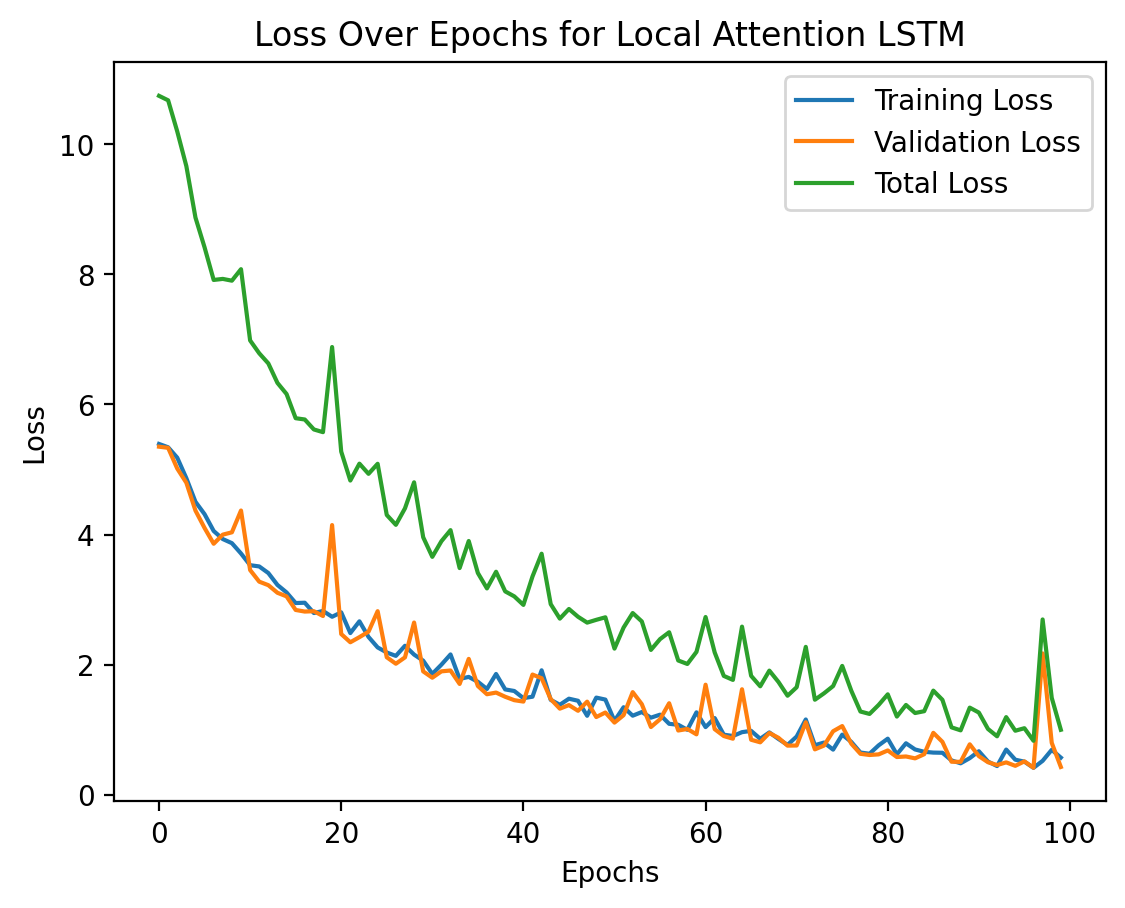

In [21]:
import matplotlib.pyplot as plt

total_loss = [train + val for train, val in zip(history.history['loss'], history.history['val_loss'])]

min_total_loss = min(total_loss)
min_epoch = total_loss.index(min_total_loss)
print(f"Min loss {min_total_loss} at {min_epoch}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(total_loss, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs for Local Attention LSTM')
plt.legend()
plt.show()

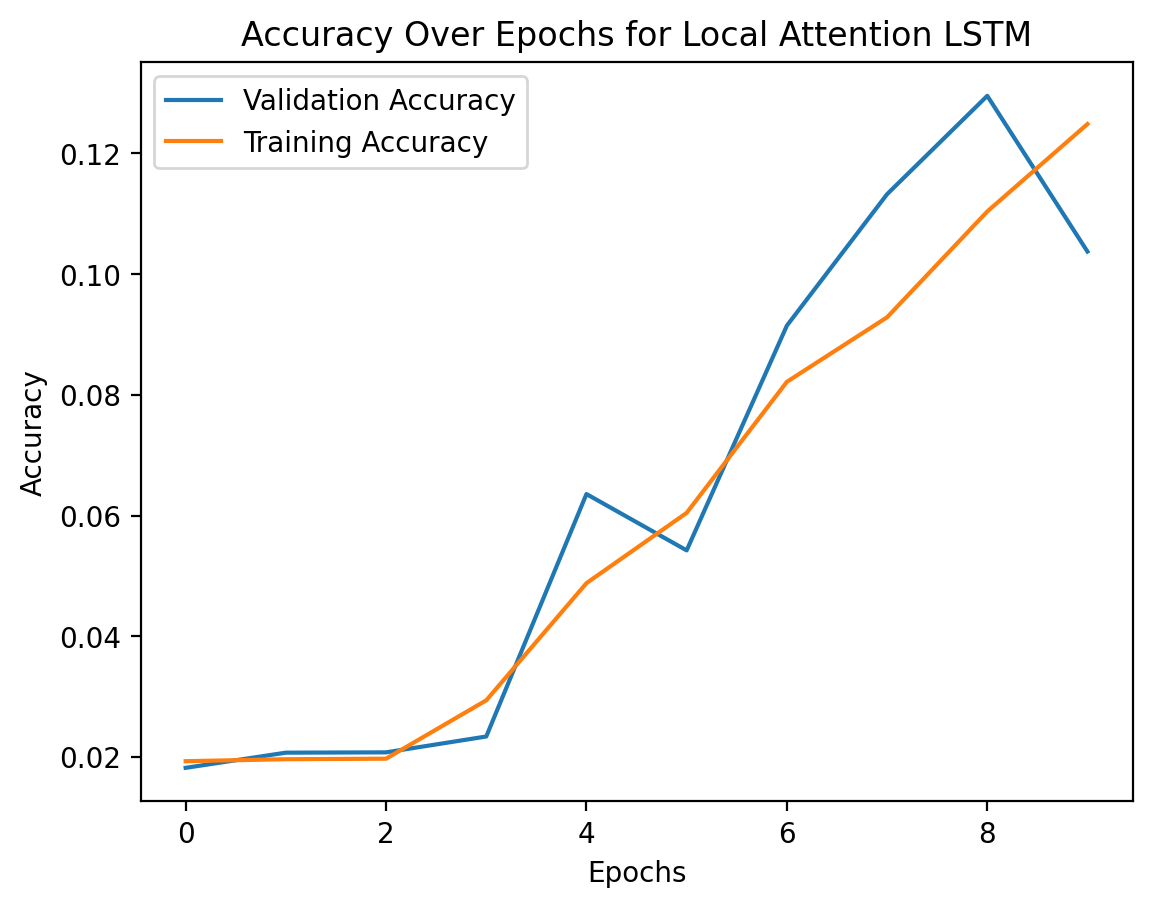

In [13]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs for Local Attention LSTM')
plt.legend()
plt.show()

#Create predictions

In [27]:
import numpy as np

def sample_with_temperature(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype('float64')

    if temperature==0.0:
      return np.argmax(predictions)

    predictions = np.log(predictions + 1e-9) / temperature
    exp_predictions = np.exp(predictions)
    predictions = exp_predictions / np.sum(exp_predictions)

    if not np.isclose(np.sum(predictions), 1):
        predictions /= np.sum(predictions)

    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)


def generate_notes(model, network_input, pitchnames, num_vocab, temperature=1.0):
    start = np.random.randint(0, len(network_input) - 1)
    int_to_note = {number: note for number, note in enumerate(pitchnames)}

    pattern = network_input[start]
    prediction_output = []

    for note_index in range(25):
        prediction_input = np.reshape(pattern, (1, -1, 1))  # Reshape for prediction

        predictions = model.predict(prediction_input)
        predictions = predictions[0]  # First sequence of predictions

        # Loop through each timestep's predictions in the sequence
        results = []
        for timestep_prediction in predictions:
            index = sample_with_temperature(timestep_prediction, temperature)
            result = int_to_note[index]
            results.append(result)

        # Use the last predicted note to continue the sequence generation
        prediction_output.extend(results)
        preds_to_inputs = [(np.argmax(curr) / float(num_vocab)) for curr in predictions]
        pattern = preds_to_inputs
        #last_note_index = np.argmax(predictions[-1])  # Use the last timestep prediction for continuing the sequence
        #pattern = np.append(pattern[1:], last_note_index / float(num_vocab))  # Update the pattern

    return prediction_output


# Usage of the function
num_vocab = len(set(flat_notes))  # Total number of unique notes
pitchnames = sorted(set(flat_notes))  # Sorted list of unique notes
prediction_output = generate_notes(model, train_input, pitchnames, num_vocab, 0)
print("Generated Sequence of Notes:", prediction_output)

1/1 [==============================] - 0s 24ms/step
Generated Sequence of Notes: ['C5', 'C3', 'C5', 'D4', 'A4', 'C3', 'A3', 'C3', 'B3', 'D5', 'C5', 'C5', 'C2', '11.2', '2.5', '0.4', 'C3', 'C2', '2.5', '5.9', 'C3', '4.7', 'C2', '11.2', '2.5', '0.4', 'C3', 'C2', '11.2', '2.5', '2.5', '0.4', '0.4.7', '7.11.2', '0.4.7', '9.11', '8.9', 'D5', '5.11', '5.11', '7.9', '6.7', 'C5', '4.7', '4.7', 'E6', 'E6', '2.5', '1.2', 'C4', 'B3', 'A3', 'D5', 'G3', 'E5', '0.2', '4.5', 'G4', 'C6', 'G#4', '9.2', 'C6', 'F5', '5.9', 'C5', 'C3', 'C5', 'D4', 'A4', 'C3', 'A3', 'C4', 'B3', 'D5', 'C5', 'C5', 'C2', '11.2', '2.5', '0.4', 'C3', 'C2', '2.5', '5.9', 'C3', '4.7', 'C2', '11.2', '2.5', '0.4', 'C3', 'C2', '11.2', '2.5', '2.5', '0.4', '0.4.7', '7.11.2', '0.4.7', '9.11', '8.9', 'D5', '5.11', '5.11', '7.9', '6.7', 'C5', '4.7', '4.7', 'E6', 'E6', '2.5', '1.2', 'C4', 'B3', 'A3', 'D5', 'G3', 'E5', '0.2', '4.5', 'G4', 'C6', 'G#4', '9.2', 'C6', 'F5', '5.9', 'C5', 'C3', 'C5', 'D4', 'A4', 'C3', 'A3', 'C5', 'B3', 'D5', 'C

In [17]:
print(prediction_output)

['B5', 'C5', 'G4', 'E4', 'E4', 'B-4', 'A5', 'E-5', 'E-5', 'F#3', 'E-5', 'F4', 'C4', 'G#4', 'C5', 'G#5', '3.6.7', 'E5', '11.1.4', 'F4', 'E5', 'E4', 'B-2', 'E-5', 'D4', '8.11.2', 'E4', 'B3', 'F5', 'B3', 'G#2', 'A3', 'B-2', 'D5', 'D5', 'E-5', 'F5', 'B4', 'G4', 'A3', '3.6', 'B-4', '8.10', 'G#3', '11.3.6', 'F#3', 'E4', '4.9', 'G3', '7.8', 'F#5', 'C#4', 'F5', '8.9', 'D4', 'B-2', '11.2', 'B4', 'B-3', '0.4', 'G#5', 'D4', 'B-3', '1.7', 'E-4', 'D4', 'F3', 'G5', 'G3', 'F4', 'A4', 'F3', 'B-3', 'F#4', 'G#2', 'A2', 'B-5', 'G3', 'C4', 'F#4', '11', 'A2', '2.4', 'A4', 'G4', 'G#2', 'A3', 'D4', 'E4', 'C#5', 'E3', 'C#5', 'F4', 'B-3', 'G#2', 'C#4', 'C#5', 'D5', 'F#3', 'B4', 'A4', 'G5', 'D4', 'C#4', '4.7', 'E4', 'E-3', 'G#4', '2.4', 'F5', 'C#5', '6.10.0', 'D5', '4.7.10', 'D4', 'F4', 'F3', 'E3', 'E-5', 'F#2', '11.2', 'F#4', 'A4', '1.3', 'F5', 'C2', 'C4', '10.1', 'G#4', 'B4', 'G#3', 'G#3', 'E-4', 'E-4', 'C3', 'A3', 'B3', 'D4', 'G#4', 'F4', 'B2', 'G4', 'E4', 'C#3', '11.0', 'F#5', '11.1', 'D3', 'F#6', 'F#4', 'B

In [28]:
from music21 import converter, instrument, note, chord, stream

def create_midi(prediction_output):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='output.mid')

create_midi(prediction_output)